# Vector Light Fields in a High NA Objective

## Introduction

The basis for this work has been completed as part of the Laboratory Practices component of the Master's Degree in Photonics program at the University of Eastern Finland. It was later recreated in the form of this Jupyter notebook. The purpose of this project has been to investigate the field that is formed by the focusing of cylindrical vector (CV) beams by an objective lens with a high numerical aperture (N.A.). These investigations follow for the work Dr. Qiwen Zhan in [Cylindrical vector beams: from mathematical concepts to applications](https://www.osapublishing.org/aop/fulltext.cfm?uri=aop-1-1-1&id=176226) and in particular focus on using numerical methods for solving the integrals given as Eqs. 5.21-5.23.

\begin{equation}
    \begin{aligned}
        & & E_{r}(r,\phi,z) &=  2A\cos\varphi_0\int_{0}^{\theta_\text{max}} P(\theta)\sin\theta \cos\theta J_1(kr\sin\theta)\exp[ikz\cos\theta]d\theta \\
     	& & E_{z}(r,\phi,z) &= i2A\cos\varphi_0\int_{0}^{\theta_\text{max}} P(\theta)\sin^2\theta J_0(kr\sin\theta)\exp[ikz\cos\theta]d\theta \\
        & & E_{\phi}(r,\phi,z) &= 2A\sin\varphi_0\int_{0}^{\theta_\text{max}} P(\theta)\sin\theta J_1(kr\sin\theta)\exp[ikz\cos\theta]d\theta.
    \end{aligned}
\end{equation}

Where $\varphi_0$ is the ratio of radial to azimuthal polarization in the incident CV beam, $P(\theta)$ is the power of the beam as a function of $\theta$, $J_n$ is the Bessel function of the first kind and $n$th order, $k$ is the wavenumber which is related to the wavelength ($\lambda$) by $k = 2\times\pi/\lambda$. $A$ is a collection of constants given by Eq. 5.15 as

\begin{equation}
    \begin{aligned}
        A = \frac{\pi f l_0}{\lambda}.
    \end{aligned}
\end{equation}

A full description for the derivation of these equations may be found in the paper. For a description of the cordinate system, a diagram of the system is given below.

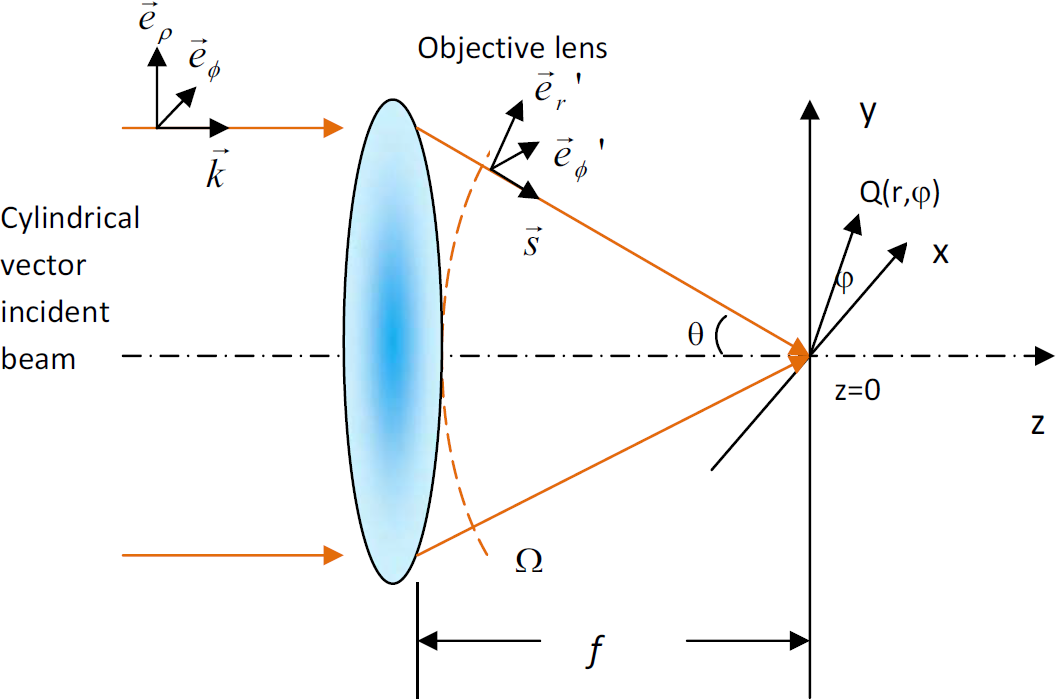

To start building the simulation it is, of course, necessary to first import the necessary libraries. I will be using the [quadpy](https://github.com/nschloe/quadpy) library here as it is more convenient for handling integration of complex functions. I am also using slightly different imports and notation than I would if I were simply writing this as I feel it improves the readability.

In [1]:
import numpy as np
from numpy import sqrt, arcsin, sin, cos, abs, exp, pi as π, arctan2 as arctan
from scipy.special import jv as J
from quadpy import quad as integrate
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Code borrowed from Joseph Long for correcting color bars, I hope to find a better 
# way to incoroporate this better in the future
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

The next step will be to define constants and parameters as they were given by my research advisor for the project, Dr. Xiaorun Zang. This includes the wavelength $\lambda$ which I selected simply as the wavelength for Fraunhofer's D line, the focal length of 1000 µm, a $\text{N.A.}$ of 0.9. was suggested by Dr. Zang, the refractive index of the lens $n$ is conveniently set equal to $n_\text{air} \approx 1$, and for reasons that will be developed later the value $l_0$ (peak field amplitude) is set as 1 and polarization has been set to approximately 0. Finally, the variable `res` is used to control the "resolution" of the resulting plots and allows for faster simulations while testing, and more detailed images when desired.

In [2]:
λ = 0.5893 # μm. Chosen as the Frounhaufer D Line
f = 1000 # focal length of the objective in µm
NA = 0.9 #Given by prompt. XZ has said High NA > 0.6.
polarization = .0001 #Used to calculate varpi angle. 0-> full radial, 90 -> full azimuthal
n = 1 #Refractive index, here approximated for n_air
l_0 = 1 #Peak field amplitude
res = 50 #adjusting will affect plot details and run times

From these parameters, it is now possible to begin solving the intermediate variables, including wavenumber, the range for $\theta$ (where the relation $\text{N.A.} = n\sin(\theta)$ is used to find the acceptance angle), $\varphi$ in radians, and $A$.

In [3]:
k = (2*π/λ)*n #wavenumber in the lens, vacuum wave number *  refractive index
θ_max = arcsin(NA) #angle of acceptance
θ = np.linspace(0, θ_max, res+1) #
𝜑_0 = polarization/180*π #defines incident polarization
A = π*f*l_0/λ

It is now necessary to consider the type of beam which is incident on the lens. The simplest case is arguably a Laguerre-Gaussian LG$_{00}$ mode, which follows the well know Gaussian distribution with radial symmetry. A simple lambda function allows for defining the power ($P$) of the beam as a function of $\theta$. The radius of the beam waist is defined to be the radius of the light gathering area of the lens as determined by the focal length and acceptance angle.

In [4]:
w = f*sin(θ_max) #radius of the beam waist
P = lambda θ: exp(-(f*sin(θ)/w)**2) # Gaussian beam, LG00 mode

Now lambda functions for each of the integrals can be defined in terms of $r$, $z$, $\theta$. This will allow for the solving of the field by integration across the range of $\theta$ for any point with coordinates $(r,z)$.

In [5]:
I_r = lambda θ,r,z: (P(θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_z = lambda θ,r,z: (P(θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_φ = lambda θ,r,z: (P(θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))


---

<center>From this point it is possible to skip to any of the following sections.</center>

---


It is now possible to perform the integration step. The first step will be to define the area of interest in terms of $(x,y,z)$. This is done by establishing the range of $x$ and $y$ in terms of units of wavelength at setting the $z$ coordinate to 0 (location of the focal point). Then using nested for loops to first solve for the $(r,z)$ coordinates and then calculating the integral at each coordinate. This results in a 2D array of data points for each function (which has been pre-allocated).

In [6]:
z = 0
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ

E_r = np.empty((len(xArray),len(yArray)), dtype = complex)
E_φ = np.empty((len(xArray),len(yArray)), dtype = complex)
E_z = np.empty((len(xArray),len(yArray)), dtype = complex)

for l in range(len(xArray)):
    for m in range(len(yArray)):
        r = sqrt(xArray[l]**2+yArray[m]**2)
        E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
        E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
        E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

The intensity of the field is given by squaring the absolute value of the field and is indicative of how the field will appear. Plotting the intensity is simply a matter of doing this for each point and using the matplotlib library to return the image. For reference, the power function is also plotted.

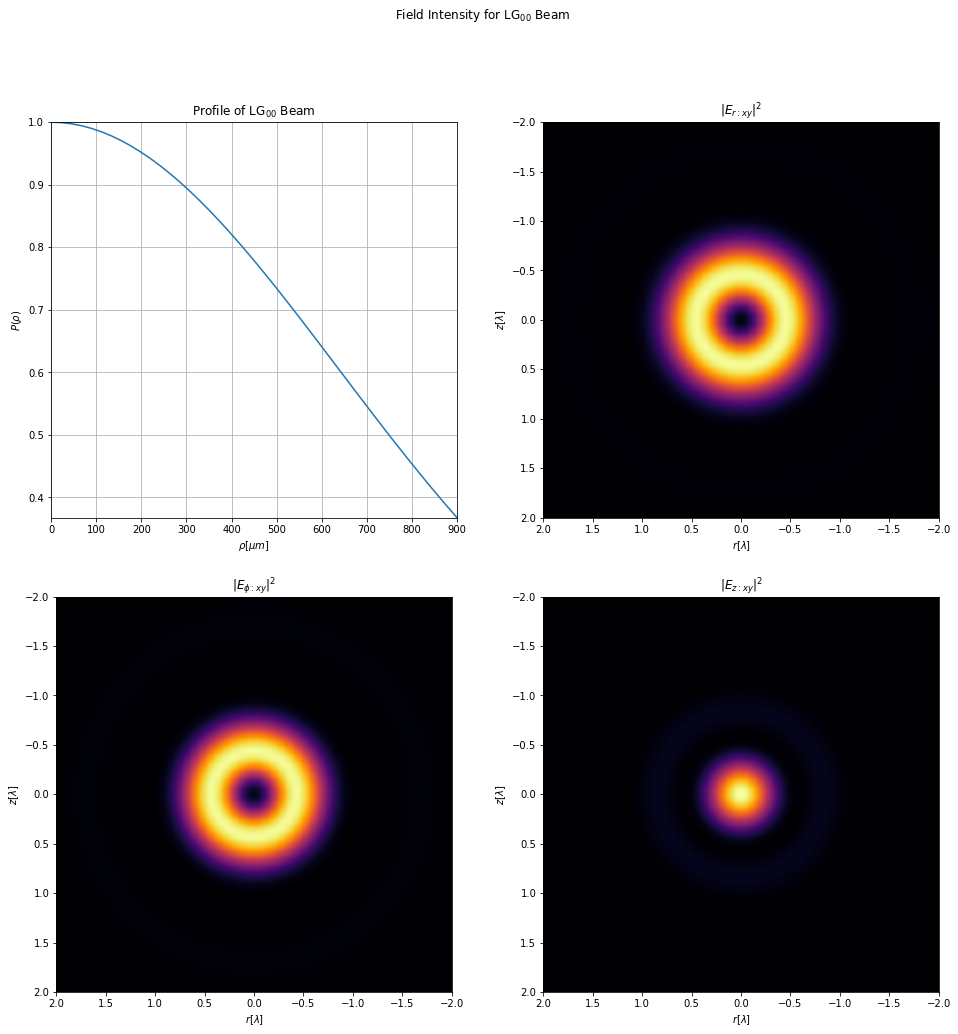

In [7]:
interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = [16, 16])
plt.suptitle('Field Intensity for LG$_{00}$ Beam')
axs[0,0].set(title = 'Profile of LG$_{00}$ Beam', xlabel = '$\\rho [\mu m]$',
           ylabel = '$P(\\rho)$', xlim = (0, f*.9), ylim = (np.min(P(θ)),1))
axs[0,0].plot(f*sin(θ),P(θ))
axs[0,0].grid()

axs[0,1].set(title = '$|E_{r:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[0,1].imshow(abs(E_r)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

axs[1,0].set(title = '$|E_{\phi:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,0].imshow(abs(E_φ)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

axs[1,1].set(title = '$|E_{z:xy}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,1].imshow(abs(E_z)**2, cmap = color, extent=[-x, x, -y, y],
              interpolation = interp)

plt.show()

It is also possible to achieve a side ($rz$-plane) view of the field by varying $z$, and applying a similar series of steps.

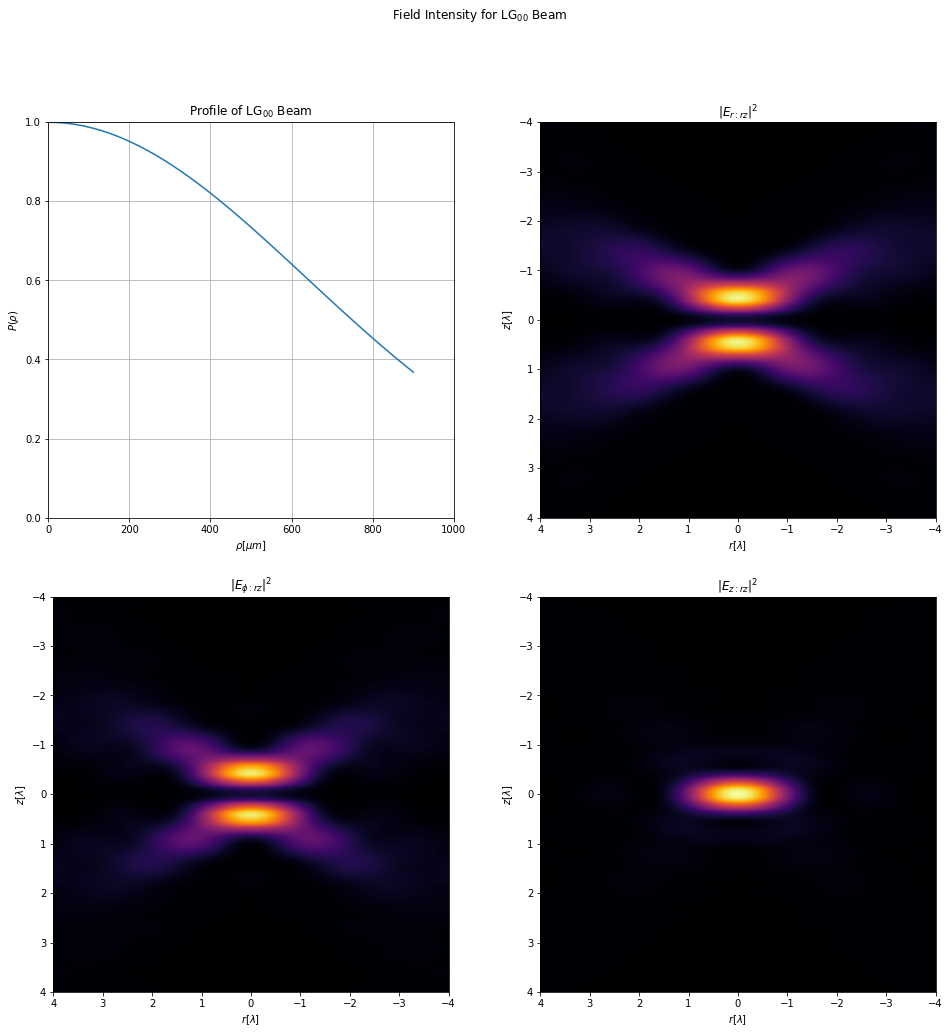

In [8]:
rArray = np.linspace(-4, 4, res)*λ 
zArray = np.linspace(-4, 4, res)*λ


for l in range(len(rArray)):
    for m in range(len(zArray)):
        z = zArray[m]
        r = rArray[l]
        E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
        E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
        E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

r = rArray[0]/λ
z = zArray[0]/λ

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = [16, 16])
plt.suptitle('Field Intensity for LG$_{00}$ Beam')
axs[0,0].set(title = 'Profile of LG$_{00}$ Beam', xlabel = '$\\rho [\mu m]$',
           ylabel = '$P(\\rho)$', xlim = (0, f), ylim = (0,1))
axs[0,0].plot(f*sin(θ),P(θ))
axs[0,0].grid()

axs[0,1].set(title = '$|E_{r:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[0,1].imshow(abs(E_r)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

axs[1,0].set(title = '$|E_{\phi:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,0].imshow(abs(E_φ)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

axs[1,1].set(title = '$|E_{z:rz}|^2$', xlabel='$r [\lambda]$', ylabel = '$z [\lambda]$')
axs[1,1].imshow(abs(E_z)**2, cmap = 'inferno', extent=[-r, r, -z, z],
              interpolation = interp)

plt.show()

## Variation of The Incident Beam Profile

There are many ways that the parameters  of the simulation may be adapted for other conditions. The first to be investigated will be the introduction of other types of beams. This is achieved  by changing the $P(\theta)$ for other types of beams. Three different beams will be tested in this simulation. The LG$_{00}$, and LG$_{10}$ modes of the Laguerre-Gaussian $lm$ modes, and a Bessel-Gaussian which has been selected to have four distinct peaks. These new profiles must first be defined in an array.

In [9]:
P = [lambda θ:exp(-(f*sin(θ)/w)**2), # LG00 profile
     lambda θ:(2*f/w*sin(θ))*exp((-(f*sin(θ)/w)**2))*sqrt(cos(θ))/np.max((2*f/w*sin(θ))*exp((-(f*sin(θ)/w)**2))*sqrt(cos(θ))),# LG10 profile
     lambda θ:((J(1, 1/36*f*sin(θ))*(exp((-(f*sin(θ)/w)**2)))*sqrt(cos(θ))))/np.max((J(1, 1/36*f*sin(θ))*(exp((-(f*sin(θ)/w)**2)))*sqrt(cos(θ))))] #Bessel profile given in handout

From here, all that is left is to perform the same series of integrations as before and plot the results. It will also be necessary to increase the plotted range for this set of simulations as the Bessel-Gaussian field requires a larger area of interest.

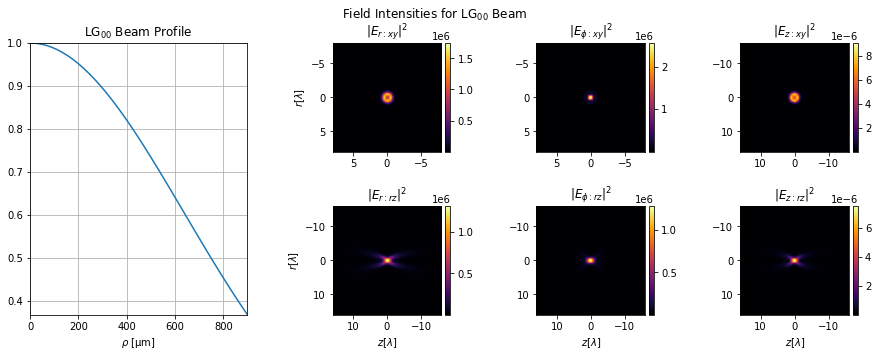

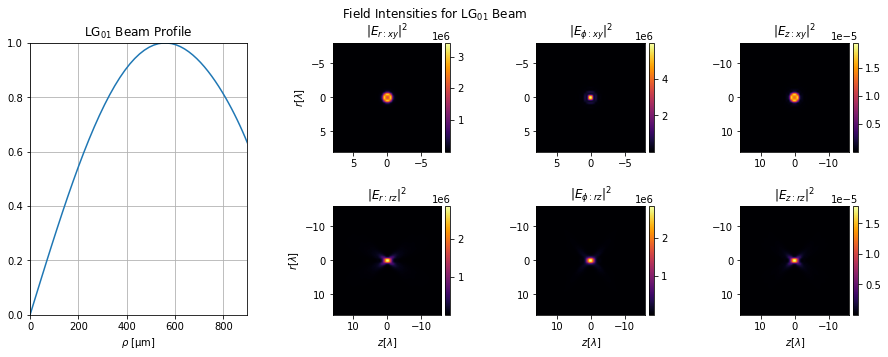

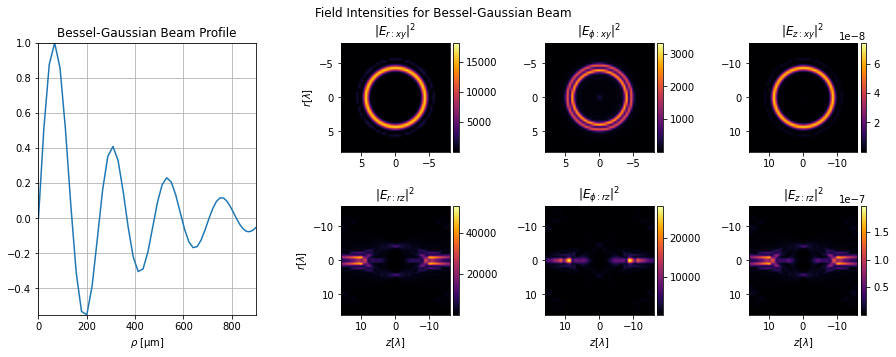

In [10]:
BeamResults = ['']*18
Titles = ['LG$_{00}$', 'LG$_{01}$', 'Bessel-Gaussian']

#A more 'zoomed out' view is convenient for viewing the Bessel-Gaussian case
xArray = np.linspace(-8, 8, res)*λ
yArray = np.linspace(-8, 8, res)*λ
rArray = np.linspace(-16, 16, res)*λ
zArray = np.linspace(-16, 16, res)*λ


#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((len(xArray),len(yArray)), dtype = complex)
E_φ = np.empty((len(xArray),len(yArray)), dtype = complex)
E_z = np.empty((len(xArray),len(yArray)), dtype = complex)

for i in range(len(P)):
    I_r = lambda θ,r,z: (P[i](θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
    I_φ = lambda θ,r,z: (P[i](θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
    I_z = lambda θ,r,z: (P[i](θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))

    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    BeamResults[6*i+0] = abs(E_r)**2 #Intensity of the E_r:xy field
    BeamResults[6*i+1] = abs(E_z)**2 #Intensity of the E_z:xy field
    BeamResults[6*i+2] = abs(E_φ)**2 #Intensity of the E_φ:xy field

    for l in range(len(rArray)):
        for m in range(len(zArray)):
            z = zArray[m]
            r = rArray[l]
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

    BeamResults[6*i+3] = abs(E_r)**2 # Intensity of the E_r:rz field
    BeamResults[6*i+4] = abs(E_z)**2 # Intensity of the E_z:rz field
    BeamResults[6*i+5] = abs(E_φ)**2 # Intensity of the E_φ:rz field
    
    #Draw plots
    interp = 'gaussian'
    color = 'inferno'
    
    x = xArray[0]/λ
    y = yArray[0]/λ
    r = rArray[0]/λ
    z = zArray[0]/λ

    fields = plt.figure(figsize = [15,5])
    
    gs0 = gridspec.GridSpec(1, 2, width_ratios=[2, 5])
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
    
    ax0 = plt.Subplot(fields, gs00[:, :])
    im0 = ax0.plot(f*sin(θ),P[i](θ))
    ax0.set(xlabel='$\\rho$ [μm]', title = Titles[i] + ' Beam Profile',
            xlim = (0, f*.9), ylim = (np.min(P[i](θ)),1))
    
    ax0.grid(), 
    fields.add_subplot(ax0)    

    
    gs01 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[1], 
                                            wspace = 0.5, hspace = 0.5)
    ax1 = plt.Subplot(fields, gs01[0, 0])
    
    im1 = ax1.imshow(BeamResults[6*i+0], cmap = color,
                     extent=[-x, x, -y, y], interpolation = interp)
    colorbar(im1)
    ax1.set_title('$|E_{r:xy}|^2$'), ax1.set_ylabel('$r [\lambda]$')
    fields.add_subplot(ax1)
    
    ax2 = plt.Subplot(fields, gs01[0, 1])
    im2 = ax2.imshow(BeamResults[6*i+1], cmap = color, 
                     extent=[-x, x, -y, y], interpolation = interp)
    colorbar(im2)
    ax2.set_title('$|E_{\phi:xy}|^2$')
    fields.add_subplot(ax2)
    
    ax3 = plt.Subplot(fields, gs01[0, 2])
    im3 = ax3.imshow(BeamResults[6*i+2], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im3)
    ax3.set(title='$|E_{z:xy}|^2$')
    fields.add_subplot(ax3)
    
    ax4 = plt.Subplot(fields, gs01[1, 0])
    im4 = ax4.imshow(BeamResults[6*i+3], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im4)
    ax4.set(title='$|E_{r:rz}|^2$', xlabel='$z [\lambda]$', 
            ylabel = '$r [\lambda]$')
    fields.add_subplot(ax4)
    
    ax5 = plt.Subplot(fields, gs01[1, 1])
    im5 = ax5.imshow(BeamResults[6*i+4], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im5)
    ax5.set(title='$|E_{\phi:rz}|^2$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax5)
    
    ax6 = plt.Subplot(fields, gs01[1, 2])
    im6 = ax6.imshow(BeamResults[6*i+5], cmap = color, 
                     extent=[-r, r, -z, z], interpolation = interp)
    colorbar(im6)
    ax6.set(title='$|E_{z:rz}|^2$', xlabel='$z [\lambda]$')
    fields.add_subplot(ax6)
    
    plt.suptitle("Field Intensities for " + Titles[i] + " Beam")
    plt.show()

With the simulation complete, it is convenient to return to the initial parameters.

In [11]:
P = lambda θ: exp(-(f*sin(θ)/w)**2)

I_r = lambda θ,r,z: (P(θ)*sin(θ)*cos(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_z = lambda θ,r,z: (P(θ)*sin(θ)**2*J(0,k*r*sin(θ))*exp(1j*k*z*cos(θ)))
I_φ = lambda θ,r,z: (P(θ)*sin(θ)*J(1,k*r*sin(θ))*exp(1j*k*z*cos(θ)))


xArray = np.linspace(-2, 2, res+1)*λ
yArray = np.linspace(-2, 2, res+3)*λ
zArray = np.linspace(-4, 4, res+1)*λ
rArray = np.linspace(-4, 4, res+3)*λ

### Observations

It is readily observed that radical changes to the resulting field may result from changing the profile of the incident beam. First, comparing just the LG$_{00}$, and LG$_{01}$ cases where the power curve is always positive, the maximum intensity for each LG$_{01}$ plot is greater than its LG$_{00}$ counterpart. This can easily be related to the fact that the area under the LG$_{00}$ profile curve is about 34% greater than the LG$_{01}$ curve. The simulations for the Bessel beam are not as easy to compare numerically as here the area under the profile curve is just 20% of the LG$_{00}$ profile. Visual observations however reveal a very different intensity profile. It is clear that the field is a now a double toroid for $|\textbf{E}_{z:xy}|^2$ versus a clear focal point as was the case in LG$_{00}$ and LG$_{01}$. This seems to mirror the undulations in the power function. A further difference is that the fields in the $zr$-plane are now very different. Rather that the field being focused around the center, it is almost exclusively at the edges. This shows that should a system like this be employed in practice great considerations should be made for what type of beam is incident.

## Variation of Wavelength

The next parameter to be varied here is the wavelength. An accepted range for the wavelengths in the optical spectrum is .4 μm to .8 μm. For this case the $\text{LG}_{00}$ mode is again used and three wavelengths are selected across this range. Again the first step will be to change the parameters specific to this simimulation and pre allocate some memory or the results of the simulation.

In [12]:
Wavelengths = np.array([0.4, 0.6, 0.8])
WavFields = ['']*len(Wavelengths)

Now the fields for each wavelength must be calculated and plotted. Code has been left such that adjusting which lines are commented out allows for the testing of any three wavelengths for any of the six planes that have been used.

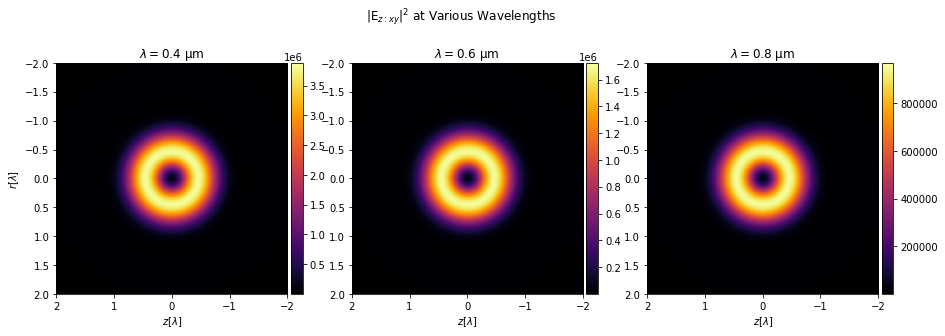

In [13]:
#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)

for i in range(len(Wavelengths)):
    λ = Wavelengths[i] # The i-th wavelength is selected
    k = 2*π/λ*n # A new wave number must be calculated
    A = π*f*l_0/λ # The wavelength is also part of the leading coeficient
    z=0
    
    #Of course as the coordinate system uses units of wavelength it must be adjusted as well
    xArray = np.linspace(-2, 2, res)*λ
    yArray = np.linspace(-2, 2, res)*λ
    rArray = np.linspace(-4, 4, res)*λ
    zArray = np.linspace(-4, 4, res)*λ
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    WavFields[i] = np.abs(E_r)**2
#    WavFields[i] = np.abs(E_z)**2
#    WavFields[i] = np.abs(E_φ)**2
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

#    WavFields[i] = np.abs(E_r)**2
#    WavFields[i] = np.abs(E_z)**2
#    WavFields[i] = np.abs(E_φ)**2

interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ
r = rArray[0]/λ
z = zArray[0]/λ

WavField = plt.figure(figsize = [15, 5])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

plt.suptitle('|E$_{z:xy}|^2$ at Various Wavelengths')
ax0 = plt.Subplot(WavField, gs00[0, 0])
im0 = ax0.imshow(WavFields[0], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax0.set(title = '$\lambda = $' + str(Wavelengths[0]) + ' µm', 
        xlabel = '$z [\lambda]$', ylabel = '$r [\lambda]$')
WavField.add_subplot(ax0)
colorbar(im0)

ax1 = plt.Subplot(WavField, gs00[0, 1])
im1 = ax1.imshow(WavFields[1], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax1.set(title = '$\lambda = $' + str(Wavelengths[1]) + ' µm', 
        xlabel = '$z [\lambda]$')
WavField.add_subplot(ax1)
colorbar(im1)

ax2 = plt.Subplot(WavField, gs00[0, 2])
im2 = ax2.imshow(WavFields[2], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax2.set(title = '$\lambda = $' + str(Wavelengths[2]) + ' µm', 
        xlabel = '$z [\lambda]$')
WavField.add_subplot(ax2)
colorbar(im2)

From above it appears that the peak intensity of the the field in a given plane is higher for smaller wavelengths. Also, while all three images appear to be the same, it is important to remember that the plots are in units of wavelength. This means that the in actuality the area of interest in the case $\lambda  = 0.4 \text{ µm}$ is a quarter the size (one half in both directions) of the $\lambda  = 0.8 \text{ µm}$ case. To investigate the wavelenghth-intensity relation a bit further, first the spectrrum is made more continous, and then the peak intensity for the field in all six planes and each wavelength is plotted.

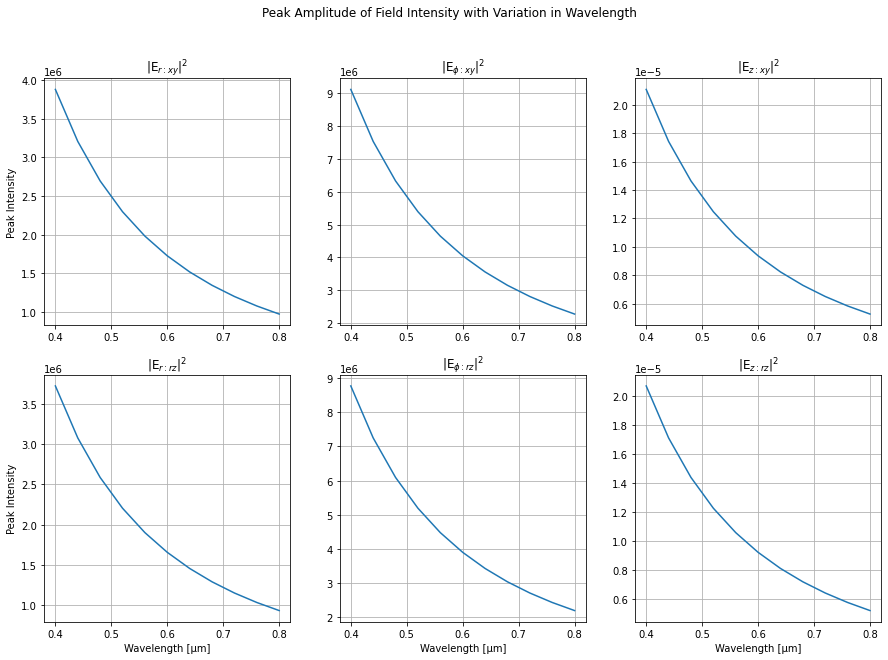

In [14]:
Wavelengths = np.linspace(0.4, 0.8, 11)
WavResults = np.empty([11,6])

#Adding this again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)

for i in range(len(Wavelengths)):
    λ = Wavelengths[i] # The i-th wavelength is selected
    k = 2*π/λ*n # A new wave number must be calculated
    A = π*f*l_0/λ # The wavelength is also part of the leading coeficient
    z=0
    
    #Of course as the coordinate system uses units of wavelength it must be adjusted as well
    xArray = np.linspace(-2, 2, res)*λ
    yArray = np.linspace(-2, 2, res)*λ
    rArray = np.linspace(-4, 4, res)*λ
    zArray = np.linspace(-4, 4, res)*λ
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    WavResults[i, 0] = np.max(abs(E_r)**2)
    WavResults[i, 1] = np.max(abs(E_z)**2)
    WavResults[i, 2] = np.max(abs(E_φ)**2)
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

    WavResults[i, 3] = np.max(abs(E_r)**2)
    WavResults[i, 4] = np.max(abs(E_z)**2)
    WavResults[i, 5] = np.max(abs(E_φ)**2)

#Plot Change in STD of Field Intensity for Wavelength 
xlabel = 'Wavelength [µm]'
ylabel = 'Peak Intensity'

WavMax = plt.figure(figsize = [15, 10])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0])

plt.suptitle("Peak Amplitude of Field Intensity with Variation in Wavelength")

ax0 = plt.Subplot(WavMax, gs00[0, 0])
im0 = ax0.plot(Wavelengths, WavResults[0:11, 0])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
WavMax.add_subplot(ax0)

ax1 = plt.Subplot(WavMax, gs00[0, 1])
im1 = ax1.plot(Wavelengths, WavResults[0:11, 1])
ax1.set(title='|E$_{\phi:xy}|^2$'), ax1.grid(), 
WavMax.add_subplot(ax1)

ax2 = plt.Subplot(WavMax, gs00[0, 2])
im2 = ax2.plot(Wavelengths, WavResults[0:11, 2])
ax2.set(title='|E$_{z:xy}|^2$'), ax2.grid(), 
WavMax.add_subplot(ax2)

ax3 = plt.Subplot(WavMax, gs00[1, 0])
im3 = ax3.plot(Wavelengths, WavResults[0:11, 3])
ax3.set(title='|E$_{r:rz}|^2$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
WavMax.add_subplot(ax3)

ax4 = plt.Subplot(WavMax, gs00[1, 1])
im4 = ax4.plot(Wavelengths, WavResults[0:11, 4])
ax4.set(title='|E$_{\phi:rz}|^2$',  xlabel = xlabel), ax4.grid(), 
WavMax.add_subplot(ax4)

ax5 = plt.Subplot(WavMax, gs00[1, 2])
im5 = ax5.plot(Wavelengths, WavResults[0:11, 5])
ax5.set(title='|E$_{z:rz}|^2$', xlabel = xlabel), ax5.grid(), 
WavMax.add_subplot(ax5)

plt.show()

### Oservations

Plotting the peak amplitudes for each wavelength and field as above shows that the trend shows a more or less exponential decay when moving from shorter wavelengths to longer ones. This is a trend that could be expected by evaluating the equations from the introduction. Noticing that the wavelength is in the denominator for both the leading coefficient term $A$, but importantly also in the calculation of wavenumber which is included in the exponential term of all three integrals. From a physical standpoint, this results point to shorter wavelength beams being more tightly focused than longer wavelengths when passed through the high N.A. objective lens. Again before moving on it is convenient to return to the original parameters to keep the simulations modular.

In [15]:
λ = 0.5893
k = 2*π/λ*n
A = π*f*l_0/λ

## Variation of Polarization

For investigations into the effect of changes in polarization, it is sensible to choose the range for $\varphi_0$ to be from  0$^\circ$ to 90$^\circ$. In other words from full radial polarization, to full azimuthal. One challenge to this is that at 0$^\circ$ the $E_r, E_z$ fields will go to zero and at 90$^\circ$ the $E_\phi$ field will go to 0. In the interest of being able to produce plots across the full range, these conditions have been approximated. As before, first, the fields for the extremes and a midpoint will be evaluated. Again, code has been left here such that other polarizations and fields may be evaluated if desired.

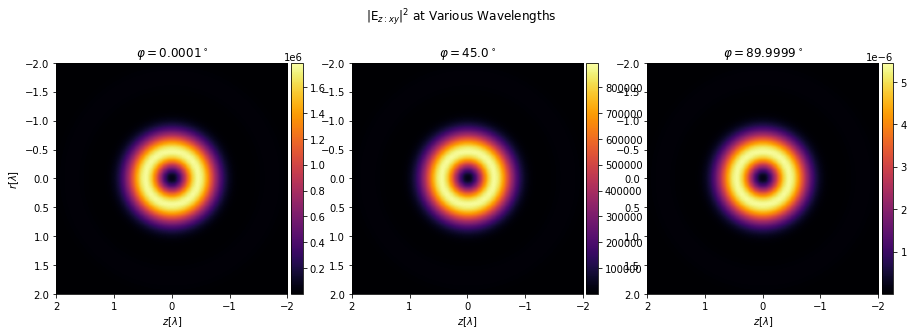

In [16]:
Polarizations = np.array([0.0001, 45, 89.9999])
PolFields = ['']*len(Polarizations)

#Adding these again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ
rArray = np.linspace(-4, 4, res)*λ
zArray = np.linspace(-4, 4, res)*λ

for i in range(len(Polarizations)):
    𝜑_0 = Polarizations[i]/180*π #defines incident polarization
    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    PolFields[i] = np.abs(E_r)**2
#    PolFields[i] = np.abs(E_z)**2
#    PolFields[i] = np.abs(E_φ)**2
    
    
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
#             E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
#             E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
#             E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

#    PolFields[i] = np.abs(E_r)**2
#    PolFields[i] = np.abs(E_z)**2
#    PolFields[i] = np.abs(E_φ)**2

interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ
r = rArray[0]/λ
z = zArray[0]/λ

PolField = plt.figure(figsize = [15, 5])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

plt.suptitle('|E$_{z:xy}|^2$ at Various Wavelengths')
ax0 = plt.Subplot(PolField, gs00[0, 0])
im0 = ax0.imshow(PolFields[0], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax0.set(title = '$\\varphi = $' + str(Polarizations[0]) + '$^\circ$', 
        xlabel = '$z [\lambda]$', ylabel = '$r [\lambda]$')
PolField.add_subplot(ax0)
colorbar(im0)

ax1 = plt.Subplot(PolField, gs00[0, 1])
im1 = ax1.imshow(PolFields[1], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax1.set(title = '$\\varphi = $' + str(Polarizations[1]) + '$^\circ$', 
        xlabel = '$z [\lambda]$')
PolField.add_subplot(ax1)
colorbar(im1)

ax2 = plt.Subplot(PolField, gs00[0, 2])
im2 = ax2.imshow(PolFields[2], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax2.set(title = '$\\varphi = $' + str(Polarizations[2]) + '$^\circ$', 
        xlabel = '$z [\lambda]$')
PolField.add_subplot(ax2)
colorbar(im2)

Again, looking at the $\textbf{E}_{z:xy}$ on its own, there is a clear trend of the intensity increasing as the polarization angle is increased. As such, it is sensible to continue carrying out the steps as before and plot the peak intensity as a function of polarization angle. Again the polarization angles will be adjusted to be less discrete. and the fields are then calculated with the max value selected, which leads to values necessary to generate the graphs for all six fields.

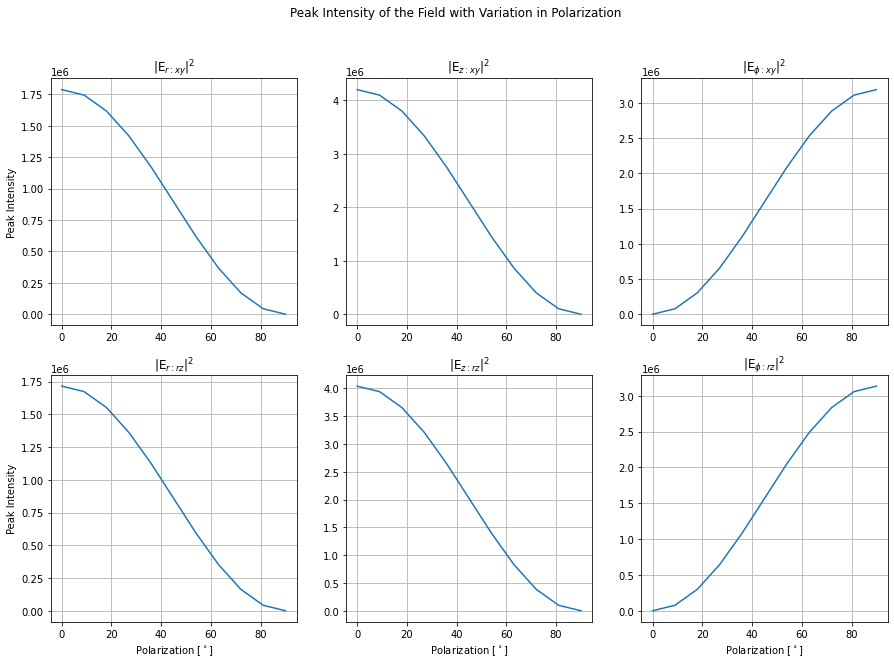

In [17]:
Polarizations = np.linspace(0.0001, 89.9999, 11)
PolResults = np.empty([11,6])

#Adding these again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ
rArray = np.linspace(-4, 4, res)*λ
zArray = np.linspace(-4, 4, res)*λ

for i in range(len(Polarizations)):
    𝜑_0 = Polarizations[i]/180*π #defines incident polarization
    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    PolResults[i, 0] = np.max(abs(E_r)**2)
    PolResults[i, 1] = np.max(abs(E_z)**2)
    PolResults[i, 2] = np.max(abs(E_φ)**2)
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

    PolResults[i, 3] = np.max(abs(E_r)**2)
    PolResults[i, 4] = np.max(abs(E_z)**2)
    PolResults[i, 5] = np.max(abs(E_φ)**2)

#Plot the change in peak intendity  of Field Intensity for Polarization angle 
xlabel = 'Polarization [$^\circ$]'
ylabel = 'Peak Intensity'

PolMax = plt.figure(figsize = [15, 10])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0])

plt.suptitle("Peak Intensity of the Field with Variation in Polarization")

ax0 = plt.Subplot(PolMax, gs00[0, 0])
im0 = ax0.plot(Polarizations, PolResults[0:11, 0])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
PolMax.add_subplot(ax0)

ax1 = plt.Subplot(PolMax, gs00[0, 1])
im1 = ax1.plot(Polarizations, PolResults[0:11, 1])
ax1.set(title='|E$_{z:xy}|^2$'), ax1.grid(), 
PolMax.add_subplot(ax1)

ax2 = plt.Subplot(PolMax, gs00[0, 2])
im2 = ax2.plot(Polarizations, PolResults[0:11, 2])
ax2.set(title='|E$_{\phi:xy}|^2$'), ax2.grid(), 
PolMax.add_subplot(ax2)

ax3 = plt.Subplot(PolMax, gs00[1, 0])
im3 = ax3.plot(Polarizations, PolResults[0:11, 3])
ax3.set(title='|E$_{r:rz}|^2$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
PolMax.add_subplot(ax3)

ax4 = plt.Subplot(PolMax, gs00[1, 1])
im4 = ax4.plot(Polarizations, PolResults[0:11, 4])
ax4.set(title='|E$_{z:rz}|^2$',  xlabel = xlabel), ax4.grid(), 
PolMax.add_subplot(ax4)

ax5 = plt.Subplot(PolMax, gs00[1, 2])
im5 = ax5.plot(Polarizations, PolResults[0:11, 5])
ax5.set(title='|E$_{\phi:rz}|^2$', xlabel = xlabel), ax5.grid(), 
PolMax.add_subplot(ax5)

plt.show()

Again thinking about the equations from the introduction this result is to be expected when behavior of $\cos$ and $\sin$ are considered. The when $\varphi_0 = 0^\circ$, $\cos(\varphi_0) = 1$ and $\sin(\varphi_0) = 0$ conversely, $\varphi_0 = 90^\circ$, $\cos(\varphi_0) = 0$ and $\sin(\varphi_0) = 1$. This leads to the conditions for each of the fields to vary from 0 to some maximum (and is again why the range for $\varphi_0$ was set to be not exactly $0^\circ$ or $90^\circ$). This result is rather boring then. A more interesting result may be found by returning to Dr. Qiwen Zhan and using Eqs. 3.1, 3.2

\begin{equation}
\textbf{E}_\text{in} = \vec{e}_x + j\vec{e}_y = (\cos (\phi \vec{e}_r)- \sin (\phi \vec{e}_\phi)) + j(\sin (\phi \vec{e}_r) + \cos (\phi \vec{e}_\phi)) = e^{j \phi}(\vec{e}_r + j\vec{e}_\phi) \\
\textbf{E}_\text{out} = e^{j \phi}\vec{e}_r.
\end{equation}

Here Zhan has first considered the expression for circularly polarized light in the input field, which leads to the expression for the polarization of the output field. Considering this will allow for the transverse field in the focal plane to be solved for and plotted in the form of a vector field. Only the real results in the $xy$-plane will be considered as the as the input LG$_{00}$ mode is purely real here, and the intent is simply to observe how, in a general case, the output would be affected by changing $\varphi_0$.

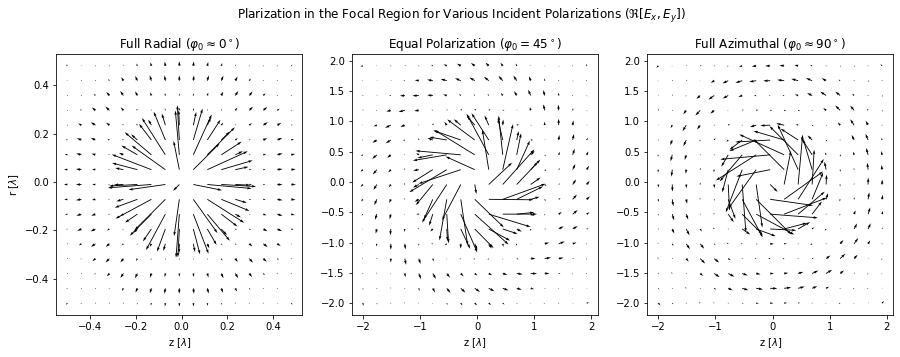

In [18]:
Polarizations = np.array([0.0001, 45, 89.9999])
VecFields = ['']*len(Polarizations)*2 #The e_x and e_y components will be saved seperately

#Adding these again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ
φ = np.empty((len(xArray),len(yArray)))
z=0
for i in range(len(Polarizations)):

    𝜑_0 = Polarizations[i]/180*π #defines incident polarization

    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = np.sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
            φ[l,m] = arctan(yArray[m], xArray[l])

    VecFields[2*i+0] = cos(φ)*E_r-sin(φ)*E_φ #e_x
    VecFields[2*i+1] = sin(φ)*E_r+cos(φ)*E_φ #e_y
    
#Plot Transverse Field in Focal Plane
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [15, 5])
[X,Y] = np.meshgrid(xArray/λ, yArray/λ)
step = 3
plt.subplots_adjust(top=.85)
plt.suptitle('Plarization in the Focal Region for Various Incident Polarizations ($\Re[E_x, E_y])$')

axs[0].set(title='Full Radial ($\\varphi_0 \\approx 0^\circ$)', xlabel='z $[\lambda]$', ylabel = 'r $[\lambda]$')
axs[0].quiver(X[::step, ::step]/4, Y[::step, ::step]/4,
              np.real(np.transpose(VecFields[0]))[::step, ::step], 
              np.real(np.transpose(VecFields[1]))[::step, ::step])

axs[1].set(title='Equal Polarization ($\\varphi_0 = 45^\circ$)', xlabel='z $[\lambda]$')
axs[1].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(VecFields[2]))[::step, ::step], 
              np.real(np.transpose(VecFields[3]))[::step, ::step])

axs[2].set(title='Full Azimuthal ($\\varphi_0 \\approx 90^\circ$)', xlabel='z $[\lambda]$')
axs[2].quiver(X[::step, ::step], Y[::step, ::step],
              np.real(np.transpose(VecFields[-2]))[::step, ::step], 
              np.real(np.transpose(VecFields[-1]))[::step, ::step])
plt.show()

### Oservations

From the above, it is seen that the output field, when the polarization is fully radial the vector field produces a source pattern with zero curl indicating that the field is radially polarized. Also, when the polarization is fully azimuthal, the curl is at a maximum, and indication that the field is azimuthal. Finally, the equal mixing of polarization results in a mix of polarizations a the focal plane. In short, the polarization of the focal field follows directly the input polarization $\varphi_0$ for the cases studied. Before moving forward the variables are returned to their standard values.

In [19]:
polarization = .0001
𝜑_0 = polarization/180*π

## Variations of Numerical Aperature

The minimum threshold for N.A. that would be considered high was suggested by Dr. Xiaorun Zang to be 0.6 for this reason, to begin the investigation for how a change in N.A. will affect the field, numerical apertures of 0.6, 0.75, 0.9 are used.

In [20]:
NAs = np.array([0.6, 0.75, 0.9])
NAFields = ['']*len(NAs)

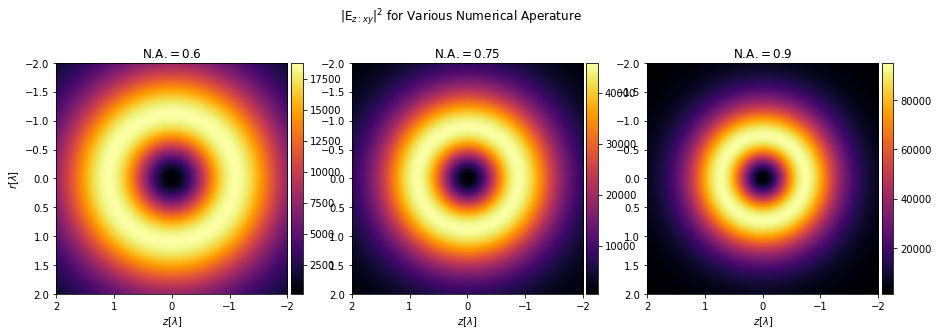

In [21]:
NAs = np.array([0.6, 0.75, 0.9])
NAFields = ['']*len(NAs)

#Adding these again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ
rArray = np.linspace(-4, 4, res)*λ
zArray = np.linspace(-4, 4, res)*λ

for i in range(len(NAs)):
    NA = NAs[i]
    
    #It will be necessary to recalculate all of the derivative variables
    θ_max = arcsin(NA)
    θ = np.linspace(0, θ_max, 201)
    w = 0.4*f*sin(θ_max)

    z=0

    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    NAFields[i] = np.abs(E_r)**2
#    NAFields[i] = np.abs(E_z)**2
#    NAFields[i] = np.abs(E_φ)**2
    
    
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
#             E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
#             E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
#             E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

#    NAFields[i] = np.abs(E_r)**2
#    NAFields[i] = np.abs(E_z)**2
#    NAFields[i] = np.abs(E_φ)**2
    
interp = 'gaussian'
color = 'inferno'

x = xArray[0]/λ
y = yArray[0]/λ
r = rArray[0]/λ
z = zArray[0]/λ

NAField = plt.figure(figsize = [15, 5])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

plt.suptitle('|E$_{z:xy}|^2$ for Various Numerical Aperature')
ax0 = plt.Subplot(NAField, gs00[0, 0])
im0 = ax0.imshow(NAFields[0], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax0.set(title = 'N.A.$ = $' + str(NAs[0]), 
        xlabel = '$z [\lambda]$', ylabel = '$r [\lambda]$')
NAField.add_subplot(ax0)
colorbar(im0)

ax1 = plt.Subplot(NAField, gs00[0, 1])
im1 = ax1.imshow(NAFields[1], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax1.set(title = 'N.A.$ = $' + str(NAs[1]), 
        xlabel = '$z [\lambda]$')
NAField.add_subplot(ax1)
colorbar(im1)

ax2 = plt.Subplot(NAField, gs00[0, 2])
im2 = ax2.imshow(NAFields[2], cmap = color, extent=[-x, x, -y, y], 
                 interpolation = interp)
ax2.set(title = 'N.A.$ = $' + str(NAs[2]), 
        xlabel = '$z [\lambda]$')
NAField.add_subplot(ax2)
colorbar(im2)

A visual inspection gives two key results here. First is that the field is more spread out when the N.A. is smaller, and less so when it is larger. This result should be expected after all since N.A. essentially defines that light-gathering power of the lens. The second observation that may be made here is that the intensity is much higher for the higher N.A. The first taken step to further understand this trend is to plot the change is the standard deviation (Std.) across the field. As Std. quantizes the how different the data points are from each other, this will start to give an idea for how focused the field is. Consider the images above. If the field is highly unfocused, it will be more spread out and all points will be closer to some average, however, when the field is more tightly focused, the variation will be much higher.

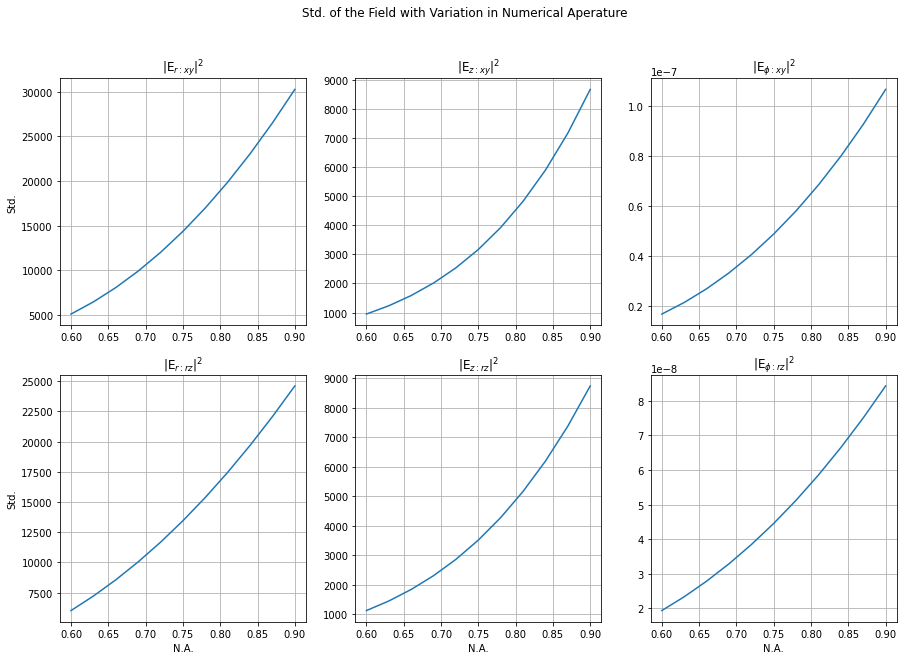

In [22]:
NAs = np.linspace(0.6, 0.9, 11)
NAResults = np.empty([11,6])

#Adding these again here helps in allowing the notebook sections to be more independent
E_r = np.empty((res, res), dtype = complex)
E_φ = np.empty((res, res), dtype = complex)
E_z = np.empty((res, res), dtype = complex)
xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ
rArray = np.linspace(-4, 4, res)*λ
zArray = np.linspace(-4, 4, res)*λ

for i in range(len(NAs)):
    NA = NAs[i]
    
    #It will be necessary to recalculate all of the derivative variables
    θ_max = arcsin(NA)
    θ = np.linspace(0, θ_max, 201)
    w = 0.4*f*sin(θ_max)

    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]
    
    NAResults[i, 0] = np.std(abs(E_r)**2)
    NAResults[i, 1] = np.std(abs(E_z)**2)
    NAResults[i, 2] = np.std(abs(E_φ)**2)
    
    for l in range(len(rArray)):
        for m in range(len(zArray)):
            r = rArray[l]
            z = zArray[m]
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            E_z[l,m] = 2j*A*cos(𝜑_0)*integrate(lambda t: I_z(t,r,z), 0, θ_max)[0]
            E_φ[l,m] = 2*A*sin(𝜑_0)*integrate(lambda t: I_φ(t,r,z), 0, θ_max)[0]

    NAResults[i, 3] = np.std(abs(E_r)**2)
    NAResults[i, 4] = np.std(abs(E_z)**2)
    NAResults[i, 5] = np.std(abs(E_φ)**2)

#Plot the change in Std.of Field Intensity for N.A. 
xlabel = 'N.A.'
ylabel = 'Std.'

NAStd = plt.figure(figsize = [15, 10])
gs0 = gridspec.GridSpec(1, 1)

gs00 = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=gs0[0])

plt.suptitle("Std. of the Field with Variation in Numerical Aperature")

ax0 = plt.Subplot(NAStd, gs00[0, 0])
im0 = ax0.plot(NAs, NAResults[0:11, 0])
ax0.set(title='|E$_{r:xy}|^2$', ylabel = ylabel), 
ax0.grid(), 
NAStd.add_subplot(ax0)

ax1 = plt.Subplot(NAStd, gs00[0, 1])
im1 = ax1.plot(NAs, NAResults[0:11, 1])
ax1.set(title='|E$_{z:xy}|^2$'), ax1.grid(), 
NAStd.add_subplot(ax1)

ax2 = plt.Subplot(NAStd, gs00[0, 2])
im2 = ax2.plot(NAs, NAResults[0:11, 2])
ax2.set(title='|E$_{\phi:xy}|^2$'), ax2.grid(), 
NAStd.add_subplot(ax2)

ax3 = plt.Subplot(NAStd, gs00[1, 0])
im3 = ax3.plot(NAs, NAResults[0:11, 3])
ax3.set(title='|E$_{r:rz}|^2$', xlabel = xlabel, ylabel = ylabel), ax3.grid(), 
NAStd.add_subplot(ax3)

ax4 = plt.Subplot(NAStd, gs00[1, 1])
im4 = ax4.plot(NAs, NAResults[0:11, 4])
ax4.set(title='|E$_{z:rz}|^2$',  xlabel = xlabel), ax4.grid(), 
NAStd.add_subplot(ax4)

ax5 = plt.Subplot(NAStd, gs00[1, 2])
im5 = ax5.plot(NAs, NAResults[0:11, 5])
ax5.set(title='|E$_{\phi:rz}|^2$', xlabel = xlabel), ax5.grid(),
NAStd.add_subplot(ax5)

plt.show()

The plots above show a seemingly exponential trend for the focusing capabilities of the objective lens for all planes. To dig deeper into the effects of adjusting N.A. notice in the above sections of code that there are many aspects of the system which are derived from the input N.A. This includes the endpoint for the range of $\theta$ which in turn adjusts the beam waist. As was shown in the simulations of different beam profiles, when the beam profile is adjusted this will affect directly intensity of the output field, and a key reason for this is that the volume of the beam changes. This has an effect here as well. In short, a higher N.A. will lead to a wider waist $w$, wwhich leads to a wider range for $\rho$, and finally, the beam will have a higher volume. To evaluate the field more fairly the beam volume (calculated as the volume integral for the beam profile) may be plotted as a function of N.A. and also compared to the Std. and volume of the $|\textbf{E}_{r:xy}|^2$ fields (calculated as the sum intensity).

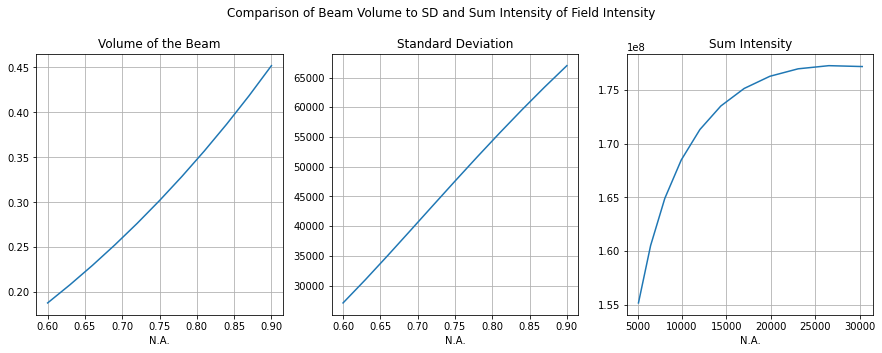

In [23]:
NAs = np.linspace(0.6, 0.9, 11)
NAResults = np.empty([11,2])

# Adding these again here helps in allowing the notebook sections to be more independent
E_z = np.empty((res, res), dtype = complex)

xArray = np.linspace(-2, 2, res)*λ
yArray = np.linspace(-2, 2, res)*λ

volResults = np.zeros([len(NAResults)])
ratResults = np.zeros([len(NAResults),2])

for i in range(len(NAs)):
    NA = NAs[i]
    
    #It will be necessary to recalculate all of the derivative variables
    θ_max = arcsin(NA)
    θ = np.linspace(0, θ_max, 201)
    w = 0.4*f*sin(θ_max)

    z=0
    
    for l in range(len(xArray)):
        for m in range(len(yArray)):
            r = sqrt(xArray[l]**2+yArray[m]**2)
            E_r[l,m] = 2*A*cos(𝜑_0)*integrate(lambda t: I_r(t,r,z), 0, θ_max)[0]
            
    # Frist, the volume and Std/ of the field  in the focal region is found by summing the intesities of all points
    NAResults[i,0] = np.std(abs(E_r)**2)
    NAResults[i,1] = np.sum(abs(E_r)**2)
    
    # Volume of beam is found using 'shell method'
    volResults[i] = integrate(lambda θ: 2*π*θ*exp(-(f*sin(θ)/w)**2), 0, θ_max)[0]
    
    # And then the ratio is calculate
    ratResults[i] = NAResults[i, 0]/volResults[i], NAResults[i, 1]/volResults[i]
#    ratResults[i] = NAResults[i]/volResults[i]# NAResults[i, 1]/volResults[i]

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = [15, 5])
plt.subplots_adjust(top = .85)
plt.suptitle('Comparison of Beam Volume to SD and Sum Intensity of Field Intensity')

axs[0].set(title='Volume of the Beam', xlabel='N.A.', )
axs[0].plot(NAs[:], volResults), axs[0].grid()

axs[1].set(title='Standard Deviation', xlabel='N.A.')
axs[1].plot(NAs[:], ratResults[:,0]), axs[1].grid()

axs[2].set(title='Sum Intensity', xlabel='N.A.')
axs[2].plot(NAResults[0:11, 0], ratResults[0:11, 1]), axs[2].grid()

plt.show()

### Observations

These plots first illustrate that the how the power of the incident beam increases directly (and almost linearly) with the change in N.A, and this then highlights the perfectly linear correlation between the resolving power of the system and the $\sin\theta_\text{max}$. Finally, it can be seen that there is a limit to the how much of the incident beam's energy will end up in the $|\textbf{E}_{r:xy}|^2$ as evidenced by the flattening of the curve when N.A. increases. The final step is return the N.A. variable to its original value such that this section will not interfere  with other sections of the notebook.

In [24]:
NA = 0.9

## Conclusions

After presenting the process of focusing a vector beam with a radially polarized electric field through a lens with a high N.A, a simulation code for evaluating the focused vector beam was constructed using numerical methods in Python. The lens system was tested under a multitude of conditions including adjustments to the incident beam profile, wavelength, field polarization, and then finally the numerical aperture its self. It was found that each of these adjustments had an impact on the field in the focal region. All beams tested resulted in a toroidal shape resembling a Laguerre-Gaussian LG$_{lm}$ mode where $l\neq 0$. The general description of the polarization of the field (radial versus azimuthal) resulted in the same type of field in the focal plane for the cases studied, and the incident polarization will have a significant impact on the intensity of the resolved beam. Wavelength will affect how focused the field is, with higher energy beams resolving quicker and therefore to a higher degree. Finally, the results of the simulation were vindicated by analysis of the field change as a result of variation in N.A. Future avenues of research in this topic include improving the simulation to accept for varying refractive index, testing under a wider variety of beams, and working to improve the overall efficiency of the simulation to maybe even allow for an interactive experience. A special thanks is given the Dr. Xiaorun Zang for his assistance in programming the simulation, as well as editing and advising this work. 

In order to help keep all of the following simulations modular, a few things related to plotting are defined. Code for keeping the color bars in place, and illustrated better was borrowed from Joseph Long's article on fixing color bars [https://joseph-long.com/writing/colorbars/]